# OpenAI Key Setting

In [ ]:
import getpass

api_key = getpass.getpass("Please enter your input API KEY :")
organization = getpass.getpass("Please enter your input ORGANIZATION ID :")

# Import Pakage and Data Setting

- LangChain 관련 : langchain, langchain-openai, langchain-community
- Document Loading 관련: unstructured, pypdf, pymupdf, arxiv
- Document Embedding 관련: sentense-transformers
- Vector Store 관련: chromadb, faiss-cpu 등
- poppler-utils: PDF 파일을 조작하고 다른 형식으로 변환하기 위한 사전 컴파일된 명령줄 유틸리티

In [ ]:
!pip install langchain
!pip install langchain-openai
!pip install langchain-community
!pip install torch torchvision
!pip install unstructured==0.5.6 unstructured-inferencenstall 
!pip install -q pypdf
!pip install pymupdf
!pip install -qU arxiv
!pip install -U sentence-transformers
!pip install chromadb
!pip install faiss-cpu
!pip install unstructured_pytesseract
!pip install -q pypdf pymupdf

!apt-get install -y poppler-utils

#### Sample data download

In [ ]:
!git clone https://github.com/tsdata/langchain-study.git
%cd langchain-study/data

In [ ]:
import os
import bs4
import numpy as np
from numpy import dot
from numpy.linalg import norm
from glob import glob
from langchain_openai import OpenAIEmbeddings
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma, FAISS
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain.schema.runnable import RunnablePassthrough
from langchain_community.document_loaders import (
    WebBaseLoader,
    TextLoader,
    DirectoryLoader,
    CSVLoader,
    PyPDFLoader, UnstructuredPDFLoader, PyMuPDFLoader, OnlinePDFLoader, PyPDFDirectoryLoader
)
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter

# 1. DataLoader

### 1-1. WebBaseLoader
- 특정 웹 페이지의 내용을 로드

In [ ]:
# WebBaseLoader
url1 = "https://blog.langchain.dev/week-of-6-10-langchain-release-notes/"
url2 = "https://blog.langchain.dev/week-of-2-5-24-langchain-release-notes/"
url3 = "https://www.skelterlabs.com/blog/2024-year-of-the-rag/"

#bs4.SoupStrainer를 사용하여 특정 클래스 이름을 가진 HTML 요소만 선택하여 파싱
loader = WebBaseLoader(
    web_paths=(url1, url2, url3),
    encoding="utf-8",
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("article-header", "article-content")
        )
    ),
)

docs = loader.load()

In [ ]:
len(docs), type(docs)

#### [Url 1 Example]
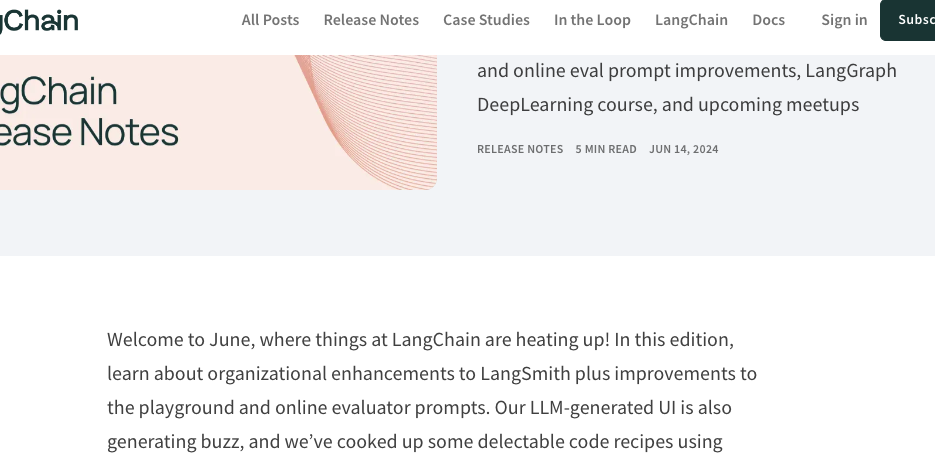

In [ ]:
print("[Metadata] ", docs[0].metadata)
print("[Page Content]", docs[0].page_content)

### 1-2. TextLodaer
- 텍스트 파일 로드

In [ ]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("history.txt")

docs = loader.load()

In [ ]:
len(docs), type(docs)

In [ ]:
print("[metadata] ", docs[0].metadata)
print("[page content] ", docs[0].page_content)

### 1-3. DirectoryLoader
- 특정 확장자를 가진 디렉토리 내 전체 로드

In [ ]:
# glob : 특정 디렉토리 내 파일 리스트 반환
files = glob(os.path.join('./', '*.txt'))
print(files)

In [ ]:
loader = DirectoryLoader(path="./", glob="*.txt") # pdf나 다른 확장자도 가능
docs = loader.load()

In [ ]:
len(docs), type(docs)

In [ ]:
print("[metadata] ", docs[1].metadata)
print("[page content] ", docs[1].page_content)

### 1-4. CSVLoader
- csv 파일 로드

In [ ]:
loader = CSVLoader(file_path="한국주택금융공사_주택금융관련_지수_20160101.csv", autodetect_encoding=True) # encoding : cp949
docs = loader.load()

In [ ]:
len(docs), type(docs)

In [ ]:
print("[metadata] ", docs[7].metadata)
print("[page content] \n", docs[7].page_content)

In [ ]:
# source_column 속성에 데이터의 출처 정보로 사용될 열의 이름을 지정
# {'source': '한국주택금융공사_주택금융관련_지수_20160101.csv', 'row': 7} -> [metadata]  {'source': '2004-01-01', 'row': 1}
loader = CSVLoader(file_path="한국주택금융공사_주택금융관련_지수_20160101.csv", source_column="연도", autodetect_encoding=True) # encoding : cp949
docs = loader.load()

In [ ]:
len(docs), type(docs)

In [ ]:
print("[metadata] ", docs[100].metadata)
print("[page content] \n", docs[100].page_content)

In [ ]:
#기존에 콤마가 아니라 구분자를 \n으로 봄.
loader = CSVLoader(file_path='한국주택금융공사_주택금융관련_지수_20160101.csv', encoding='cp949',
                   csv_args={
                       'delimiter': '\n',
                   })

docs = loader.load()

In [ ]:
len(docs), type(docs)

In [ ]:
print("[metadata] ", docs[3].metadata)
print("[page content] \n", docs[3].page_content)

### 1-5. PDFLoader
* PyPDFLoader : PDF 파일에서 텍스트 추출
* UnstructuredPDFLoader : 형식이 없는 PDF 문서 로드
* PyMuPDFLoader : 메타 데이터를 상세하게 추출
* OnlinePDFLoader : 온라인 PDF 파일 로드
* PyPDFDirectoryLoader : 특정 폴더의 모든 PDF 문서 로드

#### 1-5-1. UnstructuredPDFLoader
PDF 파일 내의 다양한 chunk를 서로 다른 ‘elements’로 생성하고, elements를 결합하여 하나의 document 객체를 생성 반환  
- “single” mode: document를 단일 Document 객체로 반환  
- “elements” mode: document를 elements로 분할하여 반환  

In [ ]:
from langchain_community.document_loaders import UnstructuredPDFLoader

loader =  UnstructuredPDFLoader(file_path="test.pdf") # 기본 모드 : single mode
docs = loader.load()

In [ ]:
print("[metadata] ", docs[0].metadata)
print("[page content] ", docs[0].page_content)

In [ ]:
from langchain_community.document_loaders import UnstructuredPDFLoader

loader =  UnstructuredPDFLoader(file_path="test.pdf", mode="elements") # elements mode
docs = loader.load()

In [ ]:
len(docs), type(docs)

In [ ]:
print("[metadata] ", docs[0].metadata)
print("[page content] ", docs[0].page_content)

print("[metadata] ", docs[2].metadata)
print("[page content] ", docs[2].page_content)

#### 1-5-2. PyPDFLoader
- PDF 문서 페이지별로 로드, 텍스트를 추출하여 documents list 객체로 반환

In [ ]:
loader = PyPDFLoader(file_path="000660_SK_2023.pdf")
pages = loader.load()

In [ ]:
len(pages), type(pages)

In [ ]:
print("[metadata] ", pages[0].metadata)
print("[page content] ", pages[0].page_content)

#### 1-5-3. PyMuPDFLoader
- PDF 파일의 페이지를 로드하고, 각 페이지를 개별 document 객체로 추출, 자세한 메타데이터 추출도 가능

In [ ]:
loader = PyMuPDFLoader(file_path="000660_SK_2023.pdf")
pages = loader.load()

In [ ]:
len(pages), type(pages)

In [ ]:
print("[metadata] ", pages[0].metadata)
print("[page content] ", pages[0].page_content)

#### 1-5-4. PyPDFDirectoryLoader
- 특정 폴더에 있는 모든 PDF 파일을 로드

In [ ]:
loader = PyPDFDirectoryLoader(path="./")
data = loader.load()

In [ ]:
len(data), type(data)

In [ ]:
print("[metadata] ", data[1].metadata)
#print("[page content] ", data[1].page_content)

print("[metadata] ", data[81].metadata)
#print("[page content] ", data[100].page_content)

print("[metadata] ", data[90].metadata)
#print("[page content] ", data[100].page_content)

#### Appendix. ArxivLoader
- https://arxiv.org/에서 논문 데이터 로드

In [ ]:
from langchain_community.document_loaders import ArxivLoader

docs = ArxivLoader(query="BART Model", load_max_docs=5).load()

In [ ]:
len(docs), type(docs)

In [ ]:
print("[metadata] ", docs[3].metadata)
print("[page content] ", docs[3].page_content)

# 2. Text Split

### 2-1. CharacterTextSplitter
- 텍스트를 문자 단위로 분할하는 데 사용되는 Class

In [ ]:
text_splitter = CharacterTextSplitter(
    separator='',
    chunk_size=100, # split 크기
    chunk_overlap=10, # split 단위 당 overlap 크기
    length_function=len
)

data = TextLoader('history.txt').load()

texts = text_splitter.split_text(data[0].page_content)

In [ ]:
len(texts[0]), len(texts[1]), len(texts[2]), len(texts[-2]), len(texts[-1])

In [ ]:
texts

In [ ]:
text_splitter = CharacterTextSplitter(
    chunk_size=100, # split 크기
    chunk_overlap=10, # split 단위 당 overlap 크기
    separator='\n',
    length_function=len
)

data = TextLoader('history.txt').load()

texts = text_splitter.split_text(data[0].page_content)

In [ ]:
len(texts[0]), len(texts[1]), len(texts[2]), len(texts[-2]), len(texts[-1])

In [ ]:
texts

### 2-2. RecursiveCharacterTextSplitter
- 텍스트를 재귀적으로 분할하는 Class

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 100,
    chunk_overlap  = 10,
    length_function = len,
)

data = TextLoader('history.txt').load()

texts = text_splitter.split_text(data[0].page_content)

In [ ]:
len(texts[0]), len(texts[1]), len(texts[-1])

In [ ]:
texts

In [ ]:
recursive_text_splitter = RecursiveCharacterTextSplitter(
    separators=['\n', ' ', ''],
    chunk_size=50, 
    chunk_overlap=2, 
)

data = TextLoader('history.txt').load()

texts = recursive_text_splitter.split_text(data[0].page_content)

In [ ]:
len(texts), len(texts[0]), len(texts[1]), len(texts[-1])

In [ ]:
texts

### 2-3. Token Encoder Splitter

In [ ]:
docs

In [ ]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder( # HuggingFace Model Tokenizer : from_huggingface_tokenizer
    chunk_size=500,
    chunk_overlap=200,
    encoding_name='cl100k_base'
)

data = TextLoader('history.txt').load()

split_texts = text_splitter.split_text(data[0].page_content)
split_docs = text_splitter.split_documents(data)

In [ ]:
len(split_texts[0]), len(split_texts[1]), len(split_texts[-1])

In [ ]:
split_texts

In [ ]:
len(split_docs)

In [ ]:
print("[metadata] ", split_docs[0].metadata)
print("[page content] ", split_docs[0].page_content)
print("[page content len] ", len(split_docs[0].page_content))

In [ ]:
print("[metadata] ", split_docs[1].metadata)
print("[page content] ", split_docs[1].page_content)
print("[page content len] ", len(split_docs[1].page_content))

# 3. Embedding

In [ ]:
# Util Method
def cos_sim(A, B):
    return dot(A, B) / (norm(A) * norm(B))

### 3-1. OpenAI Embeddings
- OpenAI API를 활용하여, 각 문서를 대응하는 임베딩 벡터로 변환

In [ ]:
embeddings_model = OpenAIEmbeddings(api_key=api_key, organization=organization)

In [ ]:
sentences = [
    '안녕하세요!',
    '어! 오랜만이에요',
    '이름이 어떻게 되세요?',
    '날씨가 추워요',
    'Hello LLM!'
]

embedded_query = embeddings_model.embed_query('첫인사를 하고 이름을 물어봤나요? 그리고 날씨는 어떤가요?')

embeddings_docs = embeddings_model.embed_documents(sentences)

In [ ]:
len(embeddings_docs), len(embeddings_docs[0]) # 하나의 문장에 대해 1536차원으로 embeddings

In [ ]:
len(embedded_query)

In [ ]:
for i, embedding in enumerate(embeddings_docs):
    print(f"[doc {i}] Sentence : {sentences[i]} ->", cos_sim(embedding, embedded_query))

### 3-2. HuggingFace Embeddings
- HuggingFace 모델에서 사용된 사전 훈련된 임베딩 모델을 다운로드 받아서 적용 가능

In [ ]:
embeddings_model = HuggingFaceEmbeddings(
    model_name="jhgan/ko-sroberta-nli", # https://huggingface.co/jhgan/ko-sroberta-nli
    model_kwargs={"device":"cpu"},
    encode_kwargs={"normalize_embeddings":True}
)

In [ ]:
sentences = [
    '안녕하세요!',
    '어! 오랜만이에요',
    '이름이 어떻게 되세요?',
    '날씨가 추워요',
    'Hello LLM!'
]

embedded_query = embeddings_model.embed_query('첫인사를 하고 이름을 물어봤나요? 그리고 날씨는 어떤가요?')

embeddings_docs = embeddings_model.embed_documents(sentences)

In [ ]:
for i, embedding in enumerate(embeddings_docs):
    print(f"[doc {i}] Sentence : {sentences[i]} ->", cos_sim(embedding, embedded_query))

# 4. Vector Store

In [ ]:
# OpenAI Embeding 사용
embeddings_model = OpenAIEmbeddings(api_key=api_key, organization=organization)

In [ ]:
# Text Data Tokenizer
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50,
    encoding_name="cl100k_base"
)
texts = text_splitter.split_text(TextLoader("history.txt").load()[0].page_content)

# PDF Data Tokenizer
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=200,
    encoding_name="cl100k_base"
)
documents = text_splitter.split_documents(PyPDFLoader("000660_SK_2023.pdf").load())

### 4-1. Chroma Search

In [ ]:
vectorDB = Chroma.from_texts(
    texts=texts,
    embedding=embeddings_model,
    collection_name="history",
    persist_directory="./db/chroma", # Vector DB 저장 위치
    collection_metadata={"hnsw:space":"cosine"} # Vector DB Opition 
)

In [ ]:
result = vectorDB.similarity_search("한글은 누가 창제 했나요?")

In [ ]:
print(result[0].page_content)

In [ ]:
result = vectorDB.similarity_search("한국은 식민지배를 받았나요?")

In [ ]:
print(result[0].page_content)

### 4-2. Chroma MMR Search 

In [ ]:
vectorDB = Chroma.from_documents(
    documents=documents,
    embedding=embeddings_model,
    collection_name="skpdf",
    persist_directory="./db/chroma", # Vector DB 저장 위치
    collection_metadata={"hnsw:space":"cosine"} # Vector DB Opition 
)

In [ ]:
query = "2022년의 SK의 직적 금액 투자 금액 중 친환경 영역의 투자 비율이 얼마나 돼?"
result_mmr = vectorDB.max_marginal_relevance_search(query=query, k=4, fetch_k=10) # fetch_k : 초기 검색 시 고려 개수, k : 최종 반환 결과 개수

In [ ]:
result_mmr[0]

### 4-3. FAISS

In [ ]:
faissDB = FAISS.from_documents(
    documents=documents,
    embedding=embeddings_model,
    distance_strategy=DistanceStrategy.COSINE
)

In [ ]:
query = "2022년의 SK의 직적 금액 투자 금액 중 친환경 영역의 투자 비율이 얼마나 돼?"
result = faissDB.similarity_search(query=query) # NON MMR

In [ ]:
result[0]

In [ ]:
query = "2022년의 SK의 직적 금액 투자 금액 중 친환경 영역의 투자 비율이 얼마나 돼?"
result_mmr = faissDB.max_marginal_relevance_search(query=query, k=4, fetch_k=10) # MMR

In [ ]:
print("Select K :", len(result_mmr))
result_mmr[0]

# 5. Vector Store Retriever

In [ ]:
# PDF Data Tokenizer
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=200,
    encoding_name="cl100k_base"
)
documents = text_splitter.split_documents(PyPDFLoader("000660_SK_2023.pdf").load())

# Embedding Model
embeddings_model = OpenAIEmbeddings(api_key=api_key, organization=organization)

# Vector DB
faissDB = FAISS.from_documents(
    documents=documents,
    embedding=embeddings_model,
    distance_strategy=DistanceStrategy.COSINE
)

#### VectorDB에서 Retriever 객체 생성

In [ ]:
retriever = faissDB.as_retriever()
type(retriever)

#### Case 1. Top K 선정

In [ ]:
retriever = faissDB.as_retriever(
    search_kwargs={"k":7}
)

In [ ]:
query = "2022년의 SK의 직적 금액 투자 금액 중 친환경 영역의 투자 비율이 얼마나 돼?"
result = retriever.get_relevant_documents(query=query)

In [ ]:
len(result), result[0]

#### Case 2. MMR Search 선정

In [ ]:
retriever = faissDB.as_retriever(
    search_type="mmr",
    search_kwargs={"k":5, "fetch_k":7}
)

In [ ]:
query = "2022년의 SK의 직적 금액 투자 금액 중 친환경 영역의 투자 비율이 얼마나 돼?"
result = retriever.get_relevant_documents(query=query)

In [ ]:
len(result), result[0]

#### Case 3. Threshold 기준으로 선정

In [ ]:
retriever = faissDB.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={'score_threshold': 0.7}
)

In [ ]:
query = "2022년의 SK의 직적 금액 투자 금액 중 친환경 영역의 투자 비율이 얼마나 돼?"
result = retriever.get_relevant_documents(query=query)

In [ ]:
len(result), result[0]

#### Case 4. 문서 객체의 metadata를 이용한 필터링

In [ ]:
# 문서 객체의 metadata를 이용한 필터링
retriever = faissDB.as_retriever(
    search_kwargs={'filter': {'page':18}}
)

In [ ]:
query = "2022년의 SK의 직적 금액 투자 금액 중 친환경 영역의 투자 비율이 얼마나 돼?"
result = retriever.get_relevant_documents(query=query)

In [ ]:
len(result), result[0]

#### Case 5. Temperature Option

In [ ]:
retriever = faissDB.as_retriever(
    search_type='mmr',
    search_kwargs={'k': 5, 'lambda_mult': 0.15} # 1에 가까울수록 diversity, 0에 가까울수록 relevance
)

In [ ]:
query = "2022년의 SK의 직적 금액 투자 금액 중 친환경 영역의 투자 비율이 얼마나 돼?"
result = retriever.get_relevant_documents(query=query)

In [ ]:
len(result), result[0:3]

#### Retriver + LLM LangChain

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Util Method
def format_docs(docs):
    return '\n\n'.join([d.page_content for d in docs])

# Retriever 선언
retriever = faissDB.as_retriever(
    search_type='mmr',
    search_kwargs={'k': 5, 'lambda_mult': 0.15}
)

# LLM Model
llm = ChatOpenAI(
    model='gpt-3.5-turbo-0125',
    temperature=0,
    max_tokens=500,
    api_key=api_key,
    organization=organization
)

# Prompt
template = '''Answer the question based only on the following context:
{context}

Question: {question}
'''

prompt = ChatPromptTemplate.from_template(template)

# LangChain
chain = prompt | llm | StrOutputParser()

In [ ]:
query = "2022년의 SK의 직적 금액 투자 금액 중 친환경 영역의 투자 비율이 얼마나 돼?"
response = chain.invoke({"context": format_docs(retriever.get_relevant_documents(query)), "question":query})

print("AIBot : ", response)

In [ ]:
query = "SK 회장이 누구야?"
response = chain.invoke({"context": format_docs(retriever.get_relevant_documents(query)), "question":query})

print("AIBot : ", response)

In [ ]:
query = "문서에 제시된 총 투자금액이 얼마야?"
response = chain.invoke({"context": format_docs(retriever.get_relevant_documents(query)), "question":query})

print("AIBot : ", response)

# 6. Multi Query Retriever
https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/MultiQueryRetriever/  

- 벡터스토어 검색도구(Vector Store Retriever)의 한계를 극복하기 위해 고안된 방법
- 단일 쿼리의 의미를 다양한 관점으로 확장하여 멀티 쿼리를 자동 생성하고, 이러한 모든 쿼리에 대한 검색 결과를 결합하여 처리
-  다양한 문장을 생성하기 위하여 LLM을 사용하여 사용자의 입력 문장을 다양한 관점으로 패러프레이징(Paraphrasing)하는 방식으로 구현

< 실행 방법 >

- MultiQueryRetriever 설정
  - from_llm 메서드를 통해, 기존 벡터저장소 검색도구(vectorstore.as_retriever())와 LLM 모델(llm)을 결합하여 MultiQueryRetriever 인스턴스를 생성  
  - 이때 LLM은 다양한 관점의 쿼리를 생성하는 데 사용

- 로깅 설정
  - 로깅을 설정하여 MultiQueryRetriever에 의해 생성되고 실행되는 쿼리들에 대한 정보를 로그로 기록하고 확인
  - 검색 과정에서 어떤 쿼리들이 생성되고 사용되었는지 확인 가능

- 문서 검색 실행
  - get_relevant_documents 메서드를 사용하여 주어진 사용자 쿼리(question)에 대해 멀티 쿼리 기반의 문서 검색을 실행
  - 생성된 모든 쿼리에 대해 문서를 검색하고, 중복을 제거하여 고유한 문서들만을 결과로 반환

In [ ]:
# PDF Data Tokenizer
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=200,
    encoding_name="cl100k_base"
)
documents = text_splitter.split_documents(PyPDFLoader("000660_SK_2023.pdf").load())

# Embedding Model
embeddings_model = OpenAIEmbeddings(api_key=api_key, organization=organization)

# Vector DB
faissDB = FAISS.from_documents(
    documents=documents,
    embedding=embeddings_model,
    distance_strategy=DistanceStrategy.COSINE
)

In [ ]:
# LLM Model
llm = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=1,
    max_tokens=500,
    api_key=api_key,
    organization=organization
)

# Multi Query Retriever
mq_retriever = MultiQueryRetriever.from_llm(
    retriever=faissDB.as_retriever(),
    llm=llm,
)

In [ ]:
query = "sk의 기업 총수는 누구야?"

In [ ]:
import logging

logging.basicConfig()
logging.getLogger('langchain.retrievers.multi_query').setLevel(logging.INFO)

result = mq_retriever.get_relevant_documents(query=query)
print(result[0])

### Mutl Query Retriver + LangChain

In [ ]:
# Util Method
def format_docs(docs):
    return '\n\n'.join([d.page_content for d in docs])

# Model
llm = ChatOpenAI(
    model='gpt-3.5-turbo-0125',
    temperature=0,
    max_tokens=500,
    api_key=api_key,
    organization=organization
)

# Multi Query Retriever
mq_retriever = MultiQueryRetriever.from_llm(
    retriever=faissDB.as_retriever(),
    llm=llm,
)

# Prompt
template = '''Answer the question based only on the following context:
{context}

Question: {question}
'''

prompt = ChatPromptTemplate.from_template(template)

In [ ]:
# Chain
chain = (
    {'context': mq_retriever | format_docs, 'question': RunnablePassthrough()} #사용자의 질문을 그대로 전달
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
response = chain.invoke("sk의 기업 총수는 누구야?")
print(response)

# 7. Contetual Compression
https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/contextual_compression/


문서 압축기는 기본 검색기로부터 얻은 문서들을 더욱 효율적으로 압축하여, 쿼리와 가장 관련이 깊은 내용만을 추려내는 것을 목표로 하고,  
쿼리와 무관한 정보를 제거하는 방시으로 답변의 품질을 높이고 비용을 줄일 수 있습니다.  
LLMChainExtractor와 ContextualCompressionRetriever 클래스를 사용합니다.  

<실행 방법>  
LLMChainExtractor와 ContextualCompressionRetriever 클래스를 사용  
* LLMChainExtractor 설정

 - LLMChainExtractor.from_llm(llm)를 사용하여 문서 압축기를 설정.
 - 언어 모델(llm)을 사용하여 문서 내용을 압축

* ContextualCompressionRetriever 설정

  - ContextualCompressionRetriever 인스턴스를 생성할 때, base_compressor와 base_retriever를 인자로 제공

  - base_compressor는 앞서 설정한 LLMChainExtractor 인스턴스이며, base_retriever는 기본 검색기 인스턴스
  - 이 두 구성 요소를 결합하여 검색된 문서들을 압축하는 과정을 처리.

* 압축된 문서 검색
 - compression_retriever.get_relevant_documents(question) 함수를 사용하여 주어진 쿼리에 대한 압축된 문서들을 검색
 - 기본 검색기를 통해 얻은 문서들을 문서 압축기를 사용하여 내용을 압축하고, 쿼리와 가장 관련된 내용만을 추려냄

* 결과 출력


In [ ]:
# LLM Model
llm = ChatOpenAI(
    model="gpt-3.5-turbo-0125",
    temperature=1,
    max_tokens=500,
    api_key=api_key,
    organization=organization
)

# PDF Data Tokenizer
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000,
    chunk_overlap=200,
    encoding_name="cl100k_base"
)
documents = text_splitter.split_documents(PyPDFLoader("000660_SK_2023.pdf").load())

# Embedding Model
embeddings_model = OpenAIEmbeddings(api_key=api_key, organization=organization)

# Vector DB
faissDB = FAISS.from_documents(
    documents=documents,
    embedding=embeddings_model,
    distance_strategy=DistanceStrategy.COSINE
)

# Retriever
base_retriever = faissDB.as_retriever(
    search_type='mmr',
    search_kwargs={'k':7, 'fetch_k': 20}
)

In [ ]:
docs = base_retriever.get_relevant_documents("sk의 기업 총수는 누구야?")
print(len(docs))

In [ ]:
docs

In [ ]:
compressor = LLMChainExtractor.from_llm(llm) # 문서 압축 모듈

compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=base_retriever
    # 압축 모델 선텍                # 기본 Retriever 선택
)

compressed_docs = compression_retriever.get_relevant_documents("sk의 환경에 대한 투자 금액은 얼마야?")
# 쿼리에 대한 압축된 문서들을 base retriever를 통해 검색 후 얻은 문서들을 문서 압축기를 사용하여 내용을 압축하여 반환

In [ ]:
print(len(compressed_docs))
print(compressed_docs)